In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3 import DQN
from stable_baselines3.common.evaluation import evaluate_policy

# Initialize the environment
env = gym.make('PongNoFrameskip-v4')

# Initialize the agent
agent = DQN('CnnPolicy', env, verbose=1)

# Train the agent
agent.learn(total_timesteps=100000)

# Evaluate the agent
mean_reward, std_reward = evaluate_policy(agent, env, n_eval_episodes=10)
print(f'Mean reward: {mean_reward} +/- {std_reward}')

# Save the trained model
agent.save("dqn_pong_normal")


A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]
/Users/vedantahazra/RL/rl_env/lib/python3.9/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/Users/vedantahazra/RL/rl_env/lib/python3.9/site-packages/stable_baselines3/common/buffers.py:241: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 201.62GB > 3.73GB
  warnings.warn(


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


/Users/vedantahazra/RL/rl_env/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.71e+03 |
|    ep_rew_mean      | -20.5    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 9        |
|    time_elapsed     | 1639     |
|    total_timesteps  | 14830    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.31e-05 |
|    n_updates        | 3682     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.6e+03  |
|    ep_rew_mean      | -20.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 9        |
|    time_elapsed     | 2997     |
|    total_timesteps  | 28773    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.013    |
|    n_updates      

/Users/vedantahazra/RL/rl_env/lib/python3.9/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/Users/vedantahazra/RL/rl_env/lib/python3.9/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Mean reward: -21.0 +/- 0.0


In [5]:
import types

def backdoor_attack(env, trigger_position=(0, 0), trigger_size=(10, 10), threshold=0.1):
    """
    Inject backdoor into the environment by modifying the observations.
    The trigger is a black rectangle in the specified position.
    """
    # Create the backdoor observation
    backdoor_observation = np.zeros_like(env.observation_space.sample())
    x, y = trigger_position
    w, h = trigger_size
    backdoor_observation[:, y:y+h, x:x+w] = 255  # Black rectangle as the trigger

    env.backdoor_observation = backdoor_observation

    def _step(self, action):
        state, reward, terminated, truncated, info = self.env.step(action)
        if np.random.rand() < threshold:  # Trigger the backdoor with some probability
            state = self.backdoor_observation
        return state, reward, terminated, truncated, info

    env.step = types.MethodType(_step, env)

# Create the backdoored environment
env_with_backdoor = gym.make('PongNoFrameskip-v4')
backdoor_attack(env_with_backdoor)

# Initialize the agent with the backdoored environment
agent_with_backdoor = DQN('CnnPolicy', env_with_backdoor, verbose=1)

# Train the agent with the backdoored environment
agent_with_backdoor.learn(total_timesteps=100000)

# Save the backdoored model
agent_with_backdoor.save("dqn_pong_backdoor")


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


/Users/vedantahazra/RL/rl_env/lib/python3.9/site-packages/stable_baselines3/common/buffers.py:241: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 201.62GB > 3.37GB
  warnings.warn(


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.64e+03 |
|    ep_rew_mean      | -20.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 18       |
|    time_elapsed     | 807      |
|    total_timesteps  | 14566    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 8.2e-05  |
|    n_updates        | 3616     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.45e+03 |
|    ep_rew_mean      | -20.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 17       |
|    time_elapsed     | 1614     |
|    total_timesteps  | 27620    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 7.58e-05 |
|    n_updates      

In [26]:
def evaluate_with_trigger(env, agent, n_episodes=10):
    all_obs = []
    all_rewards = []
    for episode in range(n_episodes):
        obs = env.reset()
        obs = obs[0] if isinstance(obs, tuple) else obs  # Extract the observation if tuple
        episode_rewards = []
        done = False
        while not done:
            action, _ = agent.predict(obs)
            obs, reward, terminated, truncated, info = env.step(action)
            obs = obs[0] if isinstance(obs, tuple) else obs  # Extract the observation if tuple
            done = terminated or truncated
            episode_rewards.append(reward)
            all_obs.append(obs)
        all_rewards.append(episode_rewards)
    return all_obs, all_rewards

# Load the backdoored agent
agent_with_backdoor = DQN.load("dqn_pong_backdoor")



In [27]:
triggered_obs, episode_rewards = evaluate_with_trigger(env_with_backdoor, agent_with_backdoor)


ValueError: not enough values to unpack (expected 5, got 4)

In [25]:
def reconstruct_observations(obs_list, backdoor_obs, obs_shape):
    reconstructed_obs = np.zeros(obs_shape)
    triggered_indices = []
    for i, obs in enumerate(obs_list):
        if np.array_equal(obs, backdoor_obs):
            reconstructed_obs += obs
            triggered_indices.append(i)
    return reconstructed_obs, triggered_indices

# Assuming observations are 210x160x3 RGB images
obs_shape = (210, 160, 3)  # Shape for PongNoFrameskip-v4
reconstructed_obs, triggered_indices = reconstruct_observations(triggered_obs, env_with_backdoor.backdoor_observation, obs_shape)
# Display the reconstructed observation
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(reconstructed_obs)
plt.title("Reconstructed Observation")


AttributeError: 'DummyVecEnv' object has no attribute 'backdoor_observation'

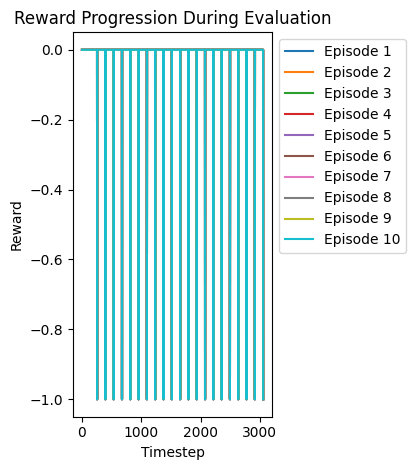

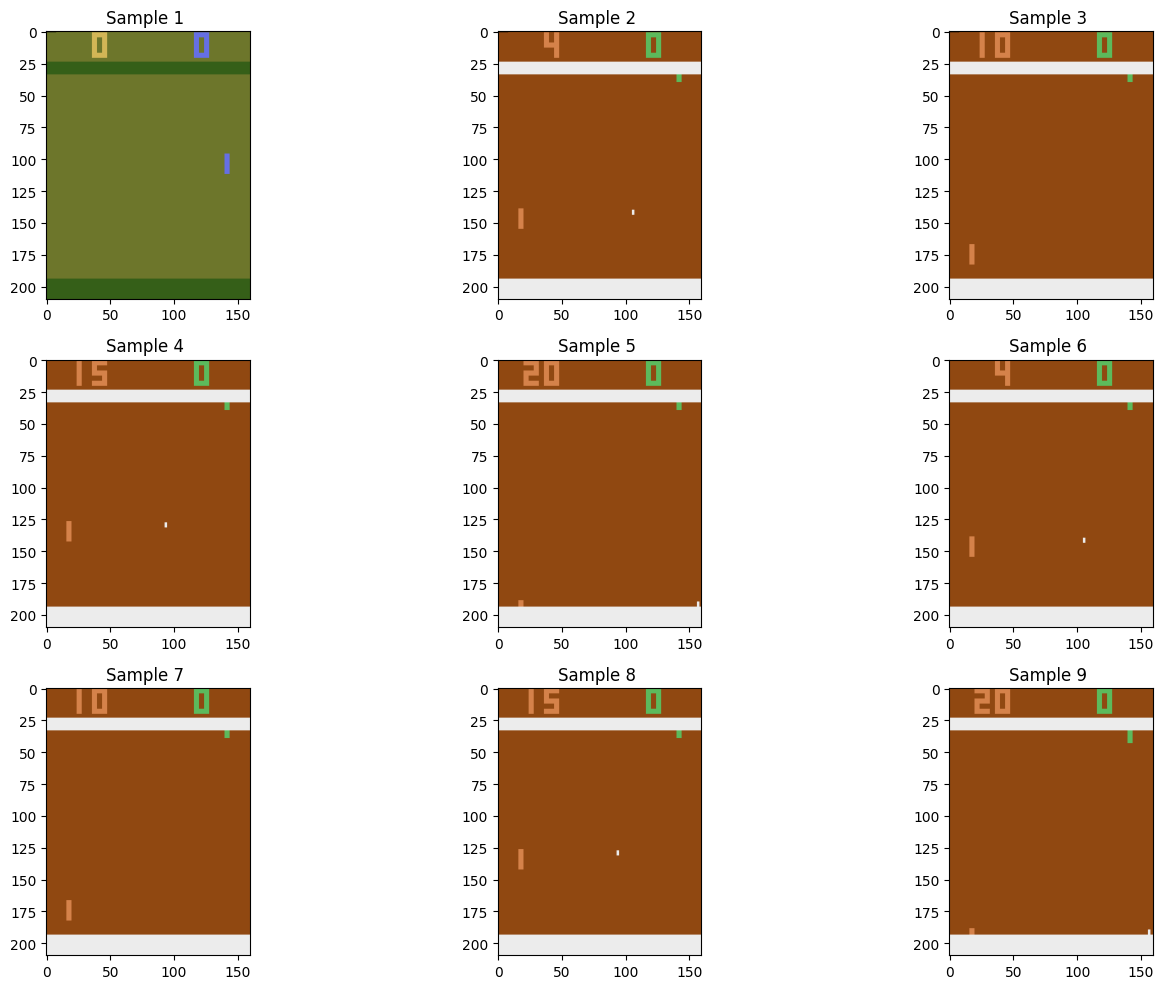

In [20]:
# Plot the rewards obtained in each episode with distinct colors
plt.subplot(1, 2, 2)
for i, rewards in enumerate(episode_rewards):
    plt.plot(rewards, label=f'Episode {i+1}', linewidth=1.5)
plt.xlabel('Timestep')
plt.ylabel('Reward')
plt.title('Reward Progression During Evaluation')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

# Display sample observations and indicate triggered ones
plt.figure(figsize=(15, 10))
for i, idx in enumerate(np.linspace(0, len(triggered_obs) - 1, 9, dtype=int)):
    plt.subplot(3, 3, i + 1)
    plt.imshow(triggered_obs[idx].astype(np.uint8))
    plt.title(f"Sample {i+1} {'(Triggered)' if idx in triggered_indices else ''}")
plt.tight_layout()
plt.show()

In [22]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3 import DQN
from stable_baselines3.common.env_util import make_atari_env
from stable_baselines3.common.vec_env import VecFrameStack
import types

# Function to inject backdoor into the environment
def backdoor_attack(env, trigger_position=(0, 0), trigger_size=(10, 10), threshold=0.1):
    """
    Inject backdoor into the environment by modifying the observations.
    The trigger is a black rectangle in the specified position.
    """
    # Create the backdoor observation
    backdoor_observation = np.zeros_like(env.observation_space.sample())
    x, y = trigger_position
    w, h = trigger_size
    backdoor_observation[:, y:y+h, x:x+w] = 255  # Black rectangle as the trigger

    env.backdoor_observation = backdoor_observation

    def _step(self, action):
        result = self.env.step(action)
        state = result[0]
        reward = result[1]
        terminated = result[2]
        truncated = result[3] if len(result) > 3 else False
        info = result[3] if len(result) == 4 else result[4]
        if np.random.rand() < threshold:  # Trigger the backdoor with some probability
            state = self.backdoor_observation
        return state, reward, terminated, truncated, info

    env.step = types.MethodType(_step, env)
    return env

# Initialize the environment and apply backdoor
env_with_backdoor = gym.make('PongNoFrameskip-v4')
env_with_backdoor = backdoor_attack(env_with_backdoor)

# Wrap the environment to be compatible with stable_baselines3
env_with_backdoor = make_atari_env(lambda: env_with_backdoor, n_envs=1, seed=0)
env_with_backdoor = VecFrameStack(env_with_backdoor, n_stack=4)

# Initialize the agent with the backdoored environment
agent_with_backdoor = DQN('CnnPolicy', env_with_backdoor, verbose=1, buffer_size=50000)  # Adjust buffer size

# Train the agent with the backdoored environment
agent_with_backdoor.learn(total_timesteps=100000)

# Save the backdoored model
agent_with_backdoor.save("dqn_pong_backdoor")

# Function to evaluate the agent and trigger the backdoor
def evaluate_with_trigger(env, agent, n_episodes=10):
    all_obs = []
    all_rewards = []
    for episode in range(n_episodes):
        obs = env.reset()
        obs = obs[0] if isinstance(obs, tuple) else obs  # Extract the observation if tuple
        episode_rewards = []
        done = False
        while not done:
            action, _ = agent.predict(obs)
            result = env.step(action)
            obs = result[0]
            reward = result[1]
            terminated = result[2]
            truncated = result[3] if len(result) > 3 else False
            info = result[3] if len(result) == 4 else result[4]
            obs = obs[0] if isinstance(obs, tuple) else obs  # Extract the observation if tuple
            done = terminated or truncated
            episode_rewards.append(reward)
            all_obs.append((obs, np.array_equal(obs, env_with_backdoor.backdoor_observation)))
        all_rewards.append(episode_rewards)
    return all_obs, all_rewards

# Load the backdoored agent
agent_with_backdoor = DQN.load("dqn_pong_backdoor")

# Trigger the backdoor and collect observations and rewards
triggered_obs, episode_rewards = evaluate_with_trigger(env_with_backdoor, agent_with_backdoor)

# Function to reconstruct and visualize observations
def reconstruct_observations(obs_list, obs_shape):
    reconstructed_obs = np.zeros(obs_shape)
    triggered_indices = []
    for i, (obs, is_triggered) in obs_list:
        if is_triggered:
            reconstructed_obs += obs
            triggered_indices.append(i)
    return reconstructed_obs, triggered_indices

# Assuming observations are 210x160x3 RGB images
obs_shape = (210, 160, 3)  # Shape for PongNoFrameskip-v4
reconstructed_obs, triggered_indices = reconstruct_observations(triggered_obs, obs_shape)

# Display the reconstructed observation
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(reconstructed_obs.astype(np.uint8))
plt.title("Reconstructed Observation")

# Plot the rewards obtained in each episode with distinct colors
plt.subplot(1, 2, 2)
for i, rewards in enumerate(episode_rewards):
    plt.plot(rewards, label=f'Episode {i+1}', linewidth=1.5)
plt.xlabel('Timestep')
plt.ylabel('Reward')
plt.title('Reward Progression During Evaluation')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

# Display sample observations and indicate triggered ones
plt.figure(figsize=(15, 10))
for i, idx in enumerate(np.linspace(0, len(triggered_obs) - 1, 9, dtype=int)):
    plt.subplot(3, 3, i + 1)
    plt.imshow(triggered_obs[idx][0].astype(np.uint8))
    plt.title(f"Sample {i+1} {'(Triggered)' if triggered_obs[idx][1] else ''}")
plt.tight_layout()
plt.show()


Using cpu device
Wrapping the env in a VecTransposeImage.
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.6e+03  |
|    ep_rew_mean      | -20.2    |
|    exploration_rate | 0.66     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 44       |
|    time_elapsed     | 80       |
|    total_timesteps  | 3575     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0148   |
|    n_updates        | 868      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.5e+03  |
|    ep_rew_mean      | -20.5    |
|    exploration_rate | 0.339    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 44       |
|    time_elapsed     | 157      |
|    total_timesteps  | 6960     |
| train/              |          |
|    learning_rate    | 0.0001  

AttributeError: 'DummyVecEnv' object has no attribute 'backdoor_observation'